In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

california_dataset = fetch_california_housing()
x_train, x_test, y_train, y_test = train_test_split(california_dataset.data, california_dataset.target, test_size=0.2, random_state=42)

In [2]:
import torch
from tqdm import tqdm

class LinearRegressionGradientDescent:
    def __init__(self, x, y, learning_rate: float, device: torch.device):
        self.x = x.to(device)
        self.y = y.to(device)
        self.learning_rate = learning_rate

        assert x.shape[0] == y.shape[0], "The number of samples in x_train and y_train must be equal"

        self.num_samples = y.shape[0]
        self.num_features = x.shape[1]

        self.bias = torch.zeros((1, 1)).to(device)
        self.weights = torch.zeros((self.num_features, 1)).to(device)

    def predict(self, bias, weights, x):
        return torch.matmul(x, weights) + bias

    def loss(self, y, predicted):
        # MSE loss
        return torch.mean(torch.square(y - predicted))
    
    def step(self):
        # Make predictions using the current weights and bias
        predicted = self.predict(self.bias, self.weights, self.x)
        # Get the loss 
        loss = self.loss(self.y, predicted)
        # Calculate the gradients
        delta_weights = 1 / self.num_samples * torch.matmul(self.x.T, (predicted - self.y.reshape(-1, 1)))
        delta_bias = 1 / self.num_samples * torch.sum(predicted - self.y.reshape(-1, 1))
        # Update the weights and bias
        self.weights = self.weights - self.learning_rate * delta_weights
        self.bias = self.bias - self.learning_rate * delta_bias
        return loss

Running on cuda


Training: 100%|██████████| 1000/1000 [00:15<00:00, 65.43it/s]


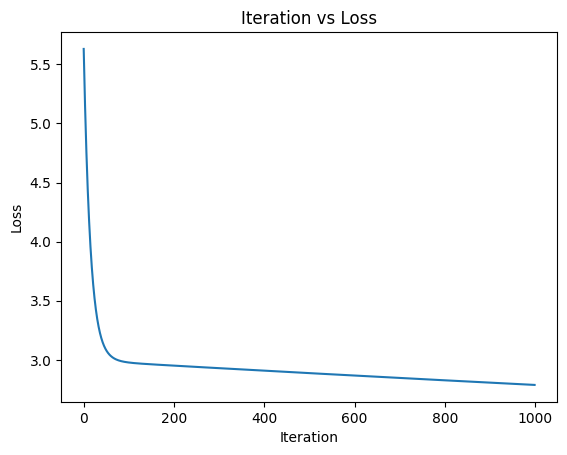

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Select the device to run the code on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print (f'Running on {device}')

iterations = 1000
learning_rate = 10e-9
model = LinearRegressionGradientDescent(torch.Tensor(x_train), torch.Tensor(y_train), learning_rate, device)
training_history = {}

for iteration in tqdm(range(iterations), desc="Training"):
    loss = model.step()
    
    loss_value = loss.cpu().numpy().item()
    bias = model.bias.cpu().detach()
    weights = model.weights.cpu().detach()
    training_history[iteration] = (loss_value, bias, weights)

plt.xlabel("Iteration")
plt.title("Iteration vs Loss")
plt.ylabel("Loss")
plt.plot(np.arange(iterations), [training_history[i][0] for i in range(iterations)])

In [4]:
def plot_predictions(num_samples: int, var_index: int, x_test, y_test, weights, bias) -> None:
    random_indices = np.random.choice(x_test.shape[0], num_samples)
    x_test = x_test[random_indices]
    y_test = y_test[random_indices]
    y_predicted = (torch.matmul(x_test, weights) + bias).flatten()

    # Calculate the MSE
    mse = torch.mean(torch.square(y_test - y_predicted))

    plt.xlabel(california_dataset.feature_names[var_index])
    plt.ylabel(california_dataset.target_names[0])
    plt.scatter(x_test[:,var_index].cpu().numpy(), y_test.cpu().numpy()) # Plot test data
    plt.scatter(x_test[:,var_index].cpu().numpy(), y_predicted.cpu().numpy(), color="k") # Plot predictions
    plt.title(f"Predictions vs actual values (MSE: {mse:.2f})")
    plt.show()

min_iteration = 0
max_iteration = iterations - 1

x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)
_, bias, weights = training_history[max_iteration]

plot_predictions(100, 3, x_test, y_test, weights, bias)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)